# 🪸 Coral Health Classification using CNN (PyTorch)
This project aims to classify coral reef images as either **Healthy** or **Bleached** using a simple Convolutional Neural Network (CNN) implemented with PyTorch.  
Dataset: [Healthy and Bleached Corals (Kaggle)](https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification)

---

1. Import Libraries

2. Download / Load Dataset

3. Data Transformations & Loaders

4. CNN Model Definition

5. Training Loop

6. Evaluation & Visualization

7. Conclusion & Ideas for Improvement

In [1]:
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset 
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]  
        x = self.transform(x)      
        return x, y

    def __len__(self):
        return len(self.subset)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),  
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
from torch.utils.data import random_split

In [5]:
data_dir = "coral_data"

dataset = datasets.ImageFolder(root=data_dir)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_subset, val_subset = random_split(dataset, [train_size, val_size])

train_dataset = TransformSubset(train_subset, train_transform)
val_dataset   = TransformSubset(val_subset, val_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=False)

In [7]:
class_names = dataset.classes
print("Classes:", class_names)
print(dataset.class_to_idx)

Classes: ['bleached_corals', 'healthy_corals']
{'bleached_corals': 0, 'healthy_corals': 1}


In [8]:
class Cnn(nn.Module):
    def __init__(self, num_classes):
        super(Cnn, self).__init__()
        self.features = nn.Sequential( # [batch_size, 3, 224, 224]
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1), nn.BatchNorm2d(64), nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1), nn.BatchNorm2d(64), nn.ReLU(), # [batch_size, 64, 224, 224]
            nn.MaxPool2d(2,2), # [batch_size, 64, 112, 112]

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1), nn.BatchNorm2d(128), nn.ReLU(), 
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1), nn.BatchNorm2d(128), nn.ReLU(), # [batch_size, 128, 112, 112]
            nn.MaxPool2d(2,2), # [batch_size, 128, 56,56]
            
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1), nn.BatchNorm2d(256), nn.ReLU(), # [batch_size, 256, 56, 56]
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2,2), # [batch_size, 256, 28, 28]

            nn.Conv2d(256, 512, kernel_size = 3, padding = 1), nn.BatchNorm2d(512), nn.ReLU(), # [batch_size, 512, 28, 28]
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(2,2), # [batch_size, 512, 14, 14]
            )
                

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*14*14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)        
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [9]:
def train(model, dataloader, criterion, optimizer, scheduler, device = "cuda"):
    model.train()
    train_losses = []
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc
        
def evaluate(model, dataloader, criterion, device = "cuda"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (labels == preds).sum().item()
            total += images.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc       

In [28]:
from collections import Counter

In [34]:
labels = [label for _, label in dataset.samples]
counts = Counter(labels)
class_counts = [counts[i] for i in range(len(class_names))]
total = sum(class_counts)

weights = [total / c for c in class_counts]
weights = [w / sum(weights) for w in weights]
weights = torch.tensor(weights, dtype=torch.float32).to(device)

In [36]:
device = "cuda"
model = Cnn(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

EPOCHS = 15

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [37]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 1/15
  Train Loss: 14.4662, Acc: 0.5894
  Val   Loss: 7.7252, Acc: 0.4973
  LR: 0.001000
Epoch 2/15
  Train Loss: 6.0834, Acc: 0.5962
  Val   Loss: 1.8090, Acc: 0.6108
  LR: 0.001000
Epoch 3/15
  Train Loss: 2.6967, Acc: 0.5867
  Val   Loss: 2.9141, Acc: 0.6378
  LR: 0.001000
Epoch 4/15
  Train Loss: 1.1183, Acc: 0.6043
  Val   Loss: 1.2823, Acc: 0.4919
  LR: 0.001000
Epoch 5/15
  Train Loss: 0.6693, Acc: 0.6667
  Val   Loss: 0.9884, Acc: 0.7405
  LR: 0.001000
Epoch 6/15
  Train Loss: 0.5812, Acc: 0.7127
  Val   Loss: 0.6696, Acc: 0.7297
  LR: 0.001000
Epoch 7/15
  Train Loss: 0.5974, Acc: 0.7046
  Val   Loss: 0.6205, Acc: 0.7189
  LR: 0.001000
Epoch 8/15
  Train Loss: 0.5937, Acc: 0.7154
  Val   Loss: 0.5629, Acc: 0.7027
  LR: 0.001000
Epoch 9/15
  Train Loss: 0.5908, Acc: 0.7114
  Val   Loss: 0.5797, Acc: 0.7135
  LR: 0.001000
Epoch 10/15
  Train Loss: 0.5533, Acc: 0.7439
  Val   Loss: 0.5685, Acc: 0.7189
  LR: 0.001000
Epoch 11/15
  Train Loss: 0.5574, Acc: 0.7276
  Val   Loss

In [38]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs ,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [50]:
preds, labels = get_all_preds(model, val_loader, device)

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

def get_probs_and_labels(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # class 1 = healthy_corals
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_probs, all_labels

probs, labels = get_probs_and_labels(model, val_loader, device)

# ROC AUC score
roc_auc = roc_auc_score(labels, probs)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.8079


Optimal Threshold: 0.56
                 precision    recall  f1-score   support

bleached_corals       0.77      0.78      0.78       104
 healthy_corals       0.71      0.70      0.71        81

       accuracy                           0.75       185
      macro avg       0.74      0.74      0.74       185
   weighted avg       0.75      0.75      0.75       185



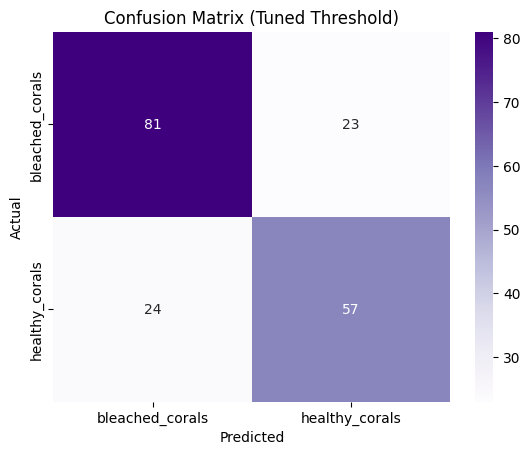

In [69]:
# threshold tuning
fpr, tpr, thresholds = roc_curve(labels, probs)

# Youden’s J statistic = TPR - FPR
youden_index = tpr - fpr
best_threshold = thresholds[youden_index.argmax()]
print(f"Optimal Threshold: {best_threshold:.2f}")

preds_thresh = (np.array(probs) > best_threshold).astype(int)

print(classification_report(labels, preds_thresh, target_names=class_names))

cm_thresh = confusion_matrix(labels, preds_thresh)
sns.heatmap(cm_thresh, annot=True, fmt="d", cmap="Purples", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned Threshold)")
plt.show()

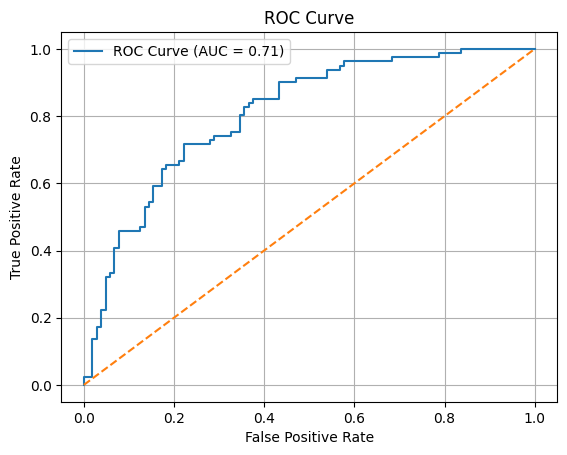

In [71]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score

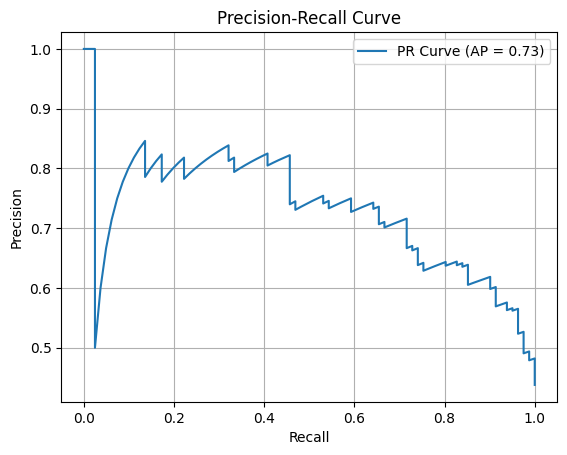

In [74]:
precision, recall, _ = precision_recall_curve(labels, probs)

ap_score = average_precision_score(labels, probs)

plt.figure()
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()